In [1]:
import arviz as az
import numpy as np
import pymc as pm
import pytensor.tensor as pt
from matplotlib import pyplot
import scipy.stats as st
import scipy.signal
import scipy.integrate
import pandas
import openpyxl
import json
import math

In [2]:
# Read example data
time = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_time.npy")
intensity = np.fromfile(fr"./His110 test data/A1_t1_1_Part2_His110_M0_m0_intensity.npy")

In [27]:
# Read example data
time_np = np.fromfile(fr"./His110 test data/A2_t2_1_Part2_His110_M0_m0_time.npy")
intensity_np = np.fromfile(fr"./His110 test data/A2_t2_1_Part2_His110_M0_m0_intensity.npy")

In [45]:
# formulation with height
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    height = pm.HalfNormal("height", 0.95 * np.max(intensity_np))
    area = pm.Deterministic("area", height/(1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    y = baseline + height * (2 * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2))))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [29]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, baseline, height, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, alpha, height]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 75 seconds.


In [29]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity_np) * 0.9)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    # posterior
    # y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))
    y = baseline + area * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2))
    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [30]:
with pmodel:
    idata2 = pm.sample_prior_predictive()
    idata2.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, area, baseline, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, alpha, area]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 77 seconds.


In [115]:
with pm.Model() as pmodel:
    # priors
    baseline = pm.Normal("baseline", 200, 100)
    noise = pm.LogNormal("noise", np.log(100), 1)
    mean = pm.Normal("mean", np.mean(time_np[[0, -1]]), np.ptp(time_np) / 2)
    std = pm.HalfNormal("std", np.ptp(time_np) / 3)
    alpha = pm.HalfNormal("alpha", 2.5)
    # noch abs() um Term in Wurzel oder sign(alpha) * Term in Wurzel
    std_skew = pm.Deterministic("std_skew", np.sqrt(std ** 2 * (1 - (2 *  alpha ** 2) / ((alpha ** 2 + 1) * np.pi))))
    # when x-axis (time) is in minutes
    area = pm.HalfNormal("area", np.max(intensity_np) * 0.9)

    # posterior with x = time = 0
    pm.Deterministic("height", area * (1 / (std * np.sqrt(2 * np.pi))))
    mean_skew = pm.Deterministic("mean_skew", mean + std * np.sqrt(2 / np.pi) * alpha / (np.sqrt(1 + alpha ** 2)))
    pm.Deterministic("height2", area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((mean_skew - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (mean_skew - mean) / std_skew)) / np.sqrt(2))))))
    mue_z = pm.Deterministic("mue_z", np.sqrt(2/np.pi) * alpha / (np.sqrt(1 + alpha ** 2)))
    sigma_z = pm.Deterministic("sigma_z",  np.sqrt(1 - mue_z ** 2))
    fit_skewness = st.skew(intensity_np)
    mode_offset = pm.Deterministic("mode_offset", mue_z - (fit_skewness * sigma_z) / 2 - (alpha/abs(alpha)) / 2 * pt.exp(- (2 * np.pi)/abs(alpha)))
    mode_skew = pm.Deterministic("mode_skew", mean_skew - (alpha / abs(alpha)) * mode_offset)

    pm.Deterministic("height3", area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((mode_skew - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (mode_skew - mean) / std)) / np.sqrt(2))))))
    # posterior
    y = baseline + area * (2 * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time_np - mean) / std)**2)) * (0.5 * (1 + pt.erf(((alpha * (time_np - mean) / std)) / np.sqrt(2)))))

    y = pm.Deterministic("y", y)

    # likelihood (auf der y-Achse liegende Normalverteilung um Datenpunkte, entspricht hier Normalverteilung um Wert mit Standardabweichung = noise)
    L = pm.Normal("L", mu=y, sigma=noise, observed=intensity_np)

In [116]:
with pmodel:
    idata3 = pm.sample_prior_predictive()
    idata3.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, area, baseline, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline, noise, mean, std, alpha, area]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 82 seconds.


[141.18, 141.18]


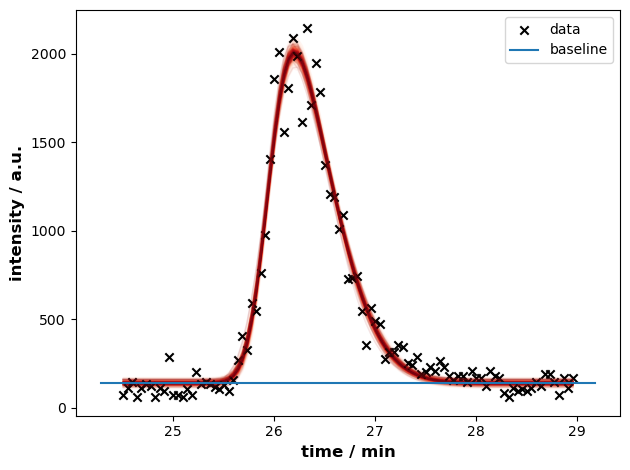

In [117]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata3.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
# plot baseline
x = np.array(ax.get_xlim())
y_baseline = az.summary(idata3).loc["baseline","mean"]
y = [y_baseline] * len(x)
print(y)
pyplot.plot(x, y, label = "baseline")
# pyplot.axvline(x = 25.95)
# pyplot.axvline(x = 26.345)
# pyplot.axvline(x = 26.488)
# pyplot.hlines([1856.0, 1807.0, 1947.0], xmin = 25, xmax = 29)
pyplot.legend()
pyplot.tight_layout()
pyplot.show()
# pyplot.savefig("Skew_A1_t1_1_Part2_His110_M0_m0.png")

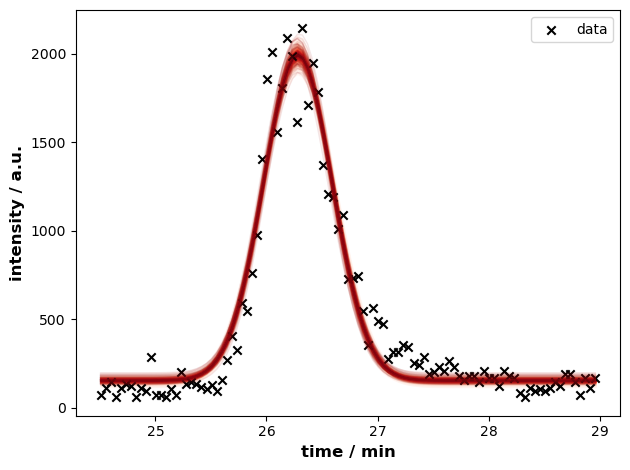

In [32]:
fig, ax = pyplot.subplots()

pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata2.posterior.y.stack(sample=("chain", "draw")).T.values,
)
pm.gp.util.plot_gp_dist(
    ax=ax,
    x=time_np,
    samples=idata3.posterior.y.stack(sample=("chain", "draw")).T.values,
)
ax.scatter(time_np, intensity_np, marker="x", color="black", label="data")
ax.set_xlabel("time / min", fontsize=12, fontweight="bold")
ax.set_ylabel("intensity / a.u.", fontsize=12, fontweight="bold")
pyplot.legend()
pyplot.tight_layout()
pyplot.show()

In [51]:
az.summary(idata3).loc[["mean", "std", "std_skew", "height", "area", "alpha", "baseline"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,25.951,0.013,25.927,25.975,0.000,0.000,3209.0,4084.0,1.0
std,0.523,0.022,0.483,0.564,0.000,0.000,2960.0,3793.0,1.0
std_skew,0.343,0.010,0.324,0.362,0.000,0.000,3421.0,4667.0,1.0
height,1739.723,39.928,1663.919,1812.976,0.494,0.350,6519.0,6402.0,1.0
area,1495.707,39.062,1423.452,1568.796,0.628,0.444,3858.0,4854.0,1.0
alpha,2.966,0.391,2.245,3.691,0.006,0.004,3772.0,4208.0,1.0
baseline,141.438,13.576,116.684,166.736,0.207,0.147,4278.0,5185.0,1.0


In [98]:
az.summary(idata3).loc[["mean", "mean_skew", "std", "std_skew", "height", "height2", "height3", "mode_skew", "area", "alpha", "baseline"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,25.950,0.013,25.926,25.974,0.000,0.000,3476.0,4136.0,1.0
mean_skew,26.346,0.012,26.322,26.368,0.000,0.000,4582.0,5680.0,1.0
std,0.524,0.022,0.483,0.565,0.000,0.000,3165.0,3977.0,1.0
std_skew,0.344,0.010,0.324,0.363,0.000,0.000,3748.0,4991.0,1.0
height,1140.975,41.064,1065.157,1217.789,0.653,0.463,4005.0,4941.0,1.0
height2,1714.813,70.773,1581.963,1844.316,1.149,0.815,3841.0,4852.0,1.0
height3,1867.151,38.615,1798.011,1942.961,0.435,0.307,7895.0,6650.0,1.0
mode_skew,26.203,0.011,26.182,26.223,0.000,0.000,6076.0,6229.0,1.0
area,1497.517,38.974,1424.722,1570.413,0.588,0.416,4396.0,5083.0,1.0
alpha,2.981,0.397,2.250,3.736,0.007,0.005,3550.0,4002.0,1.0


In [118]:
az.summary(idata3).loc[["mean", "mean_skew", "std", "std_skew", "height", "height2", "height3", "mode_skew", "area", "alpha", "baseline"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,25.951,0.013,25.925,25.975,0.000,0.000,3214.0,3543.0,1.0
mean_skew,26.345,0.012,26.323,26.368,0.000,0.000,4387.0,5522.0,1.0
std,0.523,0.022,0.482,0.564,0.000,0.000,2931.0,3252.0,1.0
std_skew,0.343,0.010,0.325,0.363,0.000,0.000,3415.0,4320.0,1.0
height,1142.184,41.515,1063.157,1218.596,0.685,0.488,3759.0,4288.0,1.0
height2,1716.948,71.323,1586.381,1852.271,1.190,0.847,3600.0,4277.0,1.0
height3,1867.291,39.863,1798.586,1947.868,0.447,0.316,7957.0,6798.0,1.0
mode_skew,26.202,0.011,26.182,26.222,0.000,0.000,5743.0,5741.0,1.0
area,1496.202,39.155,1422.618,1571.222,0.597,0.422,4302.0,4636.0,1.0
alpha,2.968,0.399,2.223,3.702,0.007,0.005,3582.0,3722.0,1.0


In [99]:
az.summary(idata3).loc["height3","mean"] + az.summary(idata3).loc["baseline","mean"]

2008.1190000000001

In [109]:
data_list = list(az.summary(idata3).iloc[:,0])
y = data_list[15:]
y

[140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.968,
 140.969,
 140.97,
 140.975,
 140.988,
 141.024,
 141.119,
 141.358,
 141.936,
 143.262,
 146.16,
 152.153,
 163.874,
 185.447,
 222.772,
 283.224,
 374.608,
 503.334,
 671.599,
 875.441,
 1103.276,
 1337.658,
 1557.932,
 1745.244,
 1885.77,
 1973.261,
 2008.459,
 1997.476,
 1949.188,
 1873.061,
 1777.568,
 1669.753,
 1554.907,
 1437.13,
 1319.323,
 1203.776,
 1092.242,
 985.944,
 885.937,
 792.845,
 707.183,
 629.117,
 558.734,
 495.852,
 440.224,
 391.489,
 349.15,
 312.722,
 281.634,
 255.352,
 233.305,
 214.981,
 199.865,
 187.509,
 177.481,
 169.413,
 162.974,
 157.873,
 153.865,
 150.739,
 148.32,
 146.462,
 145.046,
 143.974,
 143.169,
 142.569,
 142.125,
 141.798,
 141.56,
 141.387,
 141.263,
 141.174,
 141.111,
 141.067,
 141.036,
 141.014,
 140.999,
 140.989,
 140.982,
 140.977,
 140.974,
 140.972,
 140.971,
 140.97,
 140.969,
 140.969,
 140.968,
 140.968]

In [110]:
np.max(y)

2008.459

In [102]:
np.max(intensity_np)

2143.0

In [62]:
for a in intensity_np:
    if 0.95 * 1881 <= a <= 1.05 * 1881:
        print(a)

1856.0
1807.0
1947.0


In [59]:
np.sqrt(az.summary(idata3).loc["height","sd"] ** 2 + az.summary(idata3).loc["baseline","sd"] ** 2)

42.93535276435958

In [31]:
az.summary(idata2).loc[["mean", "std", "height", "area", "alpha"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,26.279,0.009,26.262,26.296,0.000,0.000,7181.0,5293.0,1.0
std,0.311,0.010,0.291,0.330,0.000,0.000,5010.0,4802.0,1.0
height,1840.697,47.630,1754.254,1933.868,0.509,0.360,8722.0,7103.0,1.0
area,1432.880,45.938,1342.742,1516.634,0.684,0.484,4522.0,4283.0,1.0
alpha,1.998,1.492,0.000,4.681,0.018,0.013,4550.0,2682.0,1.0


{24.505850000000002: 229.875, 24.5513: 229.875, 24.596766666666667: 229.875, 24.642216666666666: 229.875, 24.687683333333332: 229.875, 24.733133333333335: 229.875, 24.778599999999997: 229.875, 24.824066666666667: 229.875, 24.869516666666666: 229.875, 24.914983333333332: 229.875, 24.960433333333334: 229.875, 25.0059: 229.875, 25.05135: 229.875, 25.096816666666665: 229.875, 25.142266666666668: 229.876, 25.18773333333333: 229.88, 25.233183333333333: 229.893, 25.278650000000003: 229.931, 25.324116666666665: 230.038, 25.369566666666667: 230.325, 25.415033333333334: 231.056, 25.460483333333332: 232.817, 25.50595: 236.82, 25.5514: 245.373, 25.596866666666664: 262.534, 25.642316666666666: 294.747, 25.687783333333336: 351.259, 25.733249999999998: 443.608, 25.7787: 583.851, 25.824166666666667: 781.574, 25.869616666666666: 1039.431, 25.91508333333333: 1350.212, 25.960533333333334: 1694.876, 26.005999999999997: 2045.678, 26.05145: 2370.666, 26.09691666666667: 2641.533, 26.14238333333333: 2838.561,

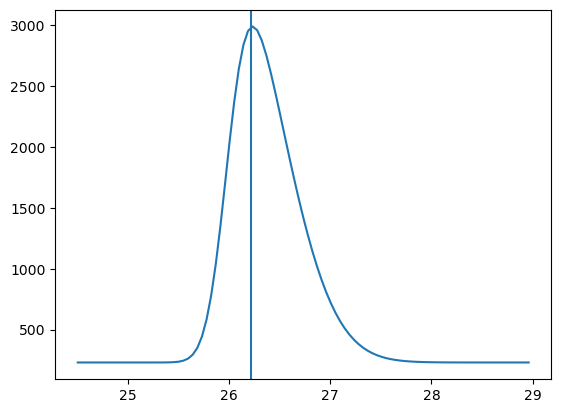

In [51]:
data_list = list(az.summary(idata).iloc[:,0])
y = data_list[7:]
y
pyplot.plot(time_np, y)
pyplot.axvline(x = 26.22195893367449)
print(dict(zip(time_np, y)))

In [33]:
raw_skewness = st.skew(intensity_np)
fit_skewness = st.skew(y)
print(raw_skewness, fit_skewness)

1.694191796628053 1.644267468365121


In [87]:
def calculate_mue_z(alpha):
    return np.sqrt(2/np.pi) * alpha / (np.sqrt(1 + alpha ** 2))

def calculate_sigma_z(mue_z):
    return np.sqrt(1 - mue_z ** 2)

def skew_mode(alpha, intensity):
    mue_z = calculate_mue_z(alpha)
    sigma_z = calculate_sigma_z(mue_z)
    fit_skewness = st.skew(intensity)

    return mue_z - (fit_skewness * sigma_z) / 2 - 1 / 2 * np.exp(- (2 * np.pi)/abs(alpha))

def mue_skew(mean, sigma, alpha):
    return mean + sigma * np.sqrt(2/np.pi) * alpha / (np.sqrt(1 + alpha ** 2))

def mode_pos(mue, skew_mode, alpha):
    if alpha < 0:
        return mue + skew_mode
    elif alpha > 0:
        return mue - skew_mode

In [88]:
alpha = az.summary(idata3).loc["alpha","mean"]
mean = az.summary(idata3).loc["mean","mean"]
sigma = az.summary(idata3).loc["std","mean"]
print(alpha)
data_list = list(az.summary(idata3).iloc[:,0])
y = data_list[8:]
print(y)

mode_test = skew_mode(alpha, y)
mue = mue_skew(mean, sigma, alpha)
mode_pos(mue, mode_test, alpha)

2.972
[26.346, 1716.41, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.367, 141.369, 141.374, 141.387, 141.423, 141.518, 141.757, 142.333, 143.655, 146.543, 152.514, 164.189, 185.68, 222.862, 283.094, 374.173, 502.528, 670.412, 873.946, 1101.639, 1336.109, 1556.709, 1744.531, 1885.65, 1973.706, 2009.354, 1998.657, 1950.486, 1874.328, 1778.692, 1670.66, 1555.558, 1437.512, 1319.441, 1203.651, 1091.901, 985.421, 885.268, 792.068, 706.334, 628.23, 557.841, 494.978, 439.394, 390.719, 348.455, 312.112, 281.114, 254.923, 232.968, 214.733, 199.702, 187.423, 177.468, 169.464, 163.082, 158.031, 154.066, 150.977, 148.589, 146.757, 145.362, 144.308, 143.517, 142.929, 142.493, 142.174, 141.941, 141.773, 141.652, 141.566, 141.505, 141.462, 141.432, 141.411, 141.397, 141.387, 141.38, 141.376, 141.373, 141.371, 141.369, 141.368, 141.368, 141.367, 141.367, 141.367]


26.16393909888036

In [15]:
delta = time_np[-1]-time_np[0]
time_np[0]+mode_test*delta

25.236685669045258

In [38]:
delta = time_np[-1]-time_np[0]
25.951+mode_test*delta

26.655320343080646

In [3]:
def initial_guesses(time, intensity):
    """
    Provide initial guesses for priors.

    Parameters
    ----------
    time
        numpy array with the time values of the relevant timeframe
    intensity
        numpy array with the intensity values of the relevant timeframe

    Returns
    -------
    baseline_fit.slope : float or int
        guess for the slope of the linear baseline prior
    baseline_fit.intercept : float or int
        guess for the intercept of the linear baseline prior
    noise_width_guess : float or int
        guess for the width of the noise
    """
    # first create a simple baseline guess only to be able to "correct" the intensity data (y_corrected = y - y_baseline)
    # then, use the corrected data to determine which data points are going to be defined as noise
    # this is the only use of the corrected data
    average_initial_intensity = np.mean([intensity[n] for n in range(3)])
    average_final_intensity = np.mean(
        [intensity[n] for n in range(len(intensity) - 3, len(intensity))]
    )
    slope_guess = (average_final_intensity - average_initial_intensity) / (time[-1] - time[0])
    # calculate intercept_guess based on the slope_guess and the formula for a linear equation
    first_intercept_guess = average_initial_intensity - slope_guess * time[0]
    intensity_corrected = [
        intensity[n] - (slope_guess * time[n] + first_intercept_guess) for n in range(len(time))
    ]

    # select lowest 35 % of all data points as noise -> noise_tuple
    intensity_tuple = list(enumerate(intensity_corrected))
    intensity_tuple.sort(key=lambda x: x[1])
    noise_range = int(np.round(0.35 * len(intensity_corrected), decimals=0))
    noise_tuple = intensity_tuple[:noise_range]
    noise_index = sorted([x[0] for x in noise_tuple])
    # use the indeces in noise_index to get the time and intensity of all noise data points
    noise_time = [time[n] for n in noise_index]
    noise_intensity = [intensity[n] for n in noise_index]
    # calculate the width of the noise
    noise_width_guess = max(noise_intensity) - min(noise_intensity)

    # use scipy to fit a linear regression through the noise as a prior for the eventual baseline
    baseline_fit = st.linregress(noise_time, noise_intensity)

    return baseline_fit.slope, baseline_fit.intercept, noise_width_guess

In [34]:
def std_skew_calculation(std, alpha):
    """Calculate the standard deviation of a skew normal distribution."""
    return np.sqrt(std**2 * (1 - (2 * alpha**2) / ((alpha**2 + 1) * np.pi)))


def mean_skew_calculation(mean, std, alpha):
    """Calculate the arithmetic mean of a skew normal distribution."""
    return mean + std * np.sqrt(2 / np.pi) * alpha / (np.sqrt(1 + alpha**2))


def mue_z_calculation(alpha):
    """Calculate the mue_z variable which is needed to compute a numerical approximation of the mode of a skew normal distribution."""
    return np.sqrt(2 / np.pi) * alpha / (np.sqrt(1 + alpha**2))


def sigma_z_calculation(mue_z):
    """Calculate the sigma_z variable which is needed to compute a numerical approximation of the mode of a skew normal distribution."""
    return np.sqrt(1 - mue_z**2)


def fit_skewness_calculation(intensity):
    """Calculate the skewness of a skew normal distribution via scipy."""
    return st.skew(intensity)


def mode_offset_calculation(mue_z, fit_skewness, sigma_z, alpha):
    """Calculate the offset between arithmetic mean and mode of a skew normal distribution."""
    return (
        mue_z
        - (fit_skewness * sigma_z) / 2
        - (alpha / abs(alpha)) / 2 * pt.exp(-(2 * np.pi) / abs(alpha))
    )


def mode_skew_calculation(mean_skew, mode_offset, alpha):
    """Calculate a numerical approximation of the mode of a skew normal distribution."""
    return mean_skew - (alpha / abs(alpha)) * mode_offset


def height_calculation(area, mean, std, alpha, mode_skew):
    """
    Calculate the height of a skew normal distribution.
    The formula is the result of inserting time = mode_skew into the posterior. Since the mode of a skew normal distribution is calculated as a numerical approximation,
    its accuracy is not perfect and thus the height's either. In tests, the height was still accurate up to and including the first two decimals.
    """
    return area * (
        2
        * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((mode_skew - mean) / std) ** 2))
        * (0.5 * (1 + pt.erf(((alpha * (mode_skew - mean) / std)) / np.sqrt(2))))
    )


def skew_normal_posterior(baseline, area, time, mean, std, alpha):
    """
    Define a skew normally distributed posterior.

    Parameters
    ----------
    baseline
        baseline of the data
    area
        peak area
    time
        numpy array with the time values of the relevant timeframe
    intensity
        numpy array with the intensity values of the relevant timeframe
    mean
        location parameter, i.e. arithmetic mean
    std
        scale parameter, i.e. standard deviation
    alpha
        skewness parameter

    Returns
    -------
    y
        Probability density function (PDF) of a univariate ordered normal distribution as the posterior
    """
    # posterior
    y = baseline + area * (
        2
        * (1 / (std * np.sqrt(2 * np.pi)) * pt.exp(-0.5 * ((time - mean) / std) ** 2))
        * (0.5 * (1 + pt.erf(((alpha * (time - mean) / std)) / np.sqrt(2))))
    )
    return y


def define_model_skew(time, intensity):
    """
    Define a model for fitting a skew normal distribution to the peak data.

    Parameters
    ----------
    time
        numpy array with the time values of the relevant timeframe
    intensity
        numpy array with the intensity values of the relevant timeframe

    Returns
    -------
    pmodel
        pymc model
    """
    print("Start")
    intercept_guess, slope_guess, noise_width_guess = initial_guesses(time, intensity)
    print("after guesses")
    with pm.Model() as pmodel:
        # priors plus error handling in case of mathematically impermissible values
        if intercept_guess == 0:
            baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
        else:
            baseline_intercept = pm.Normal(
                "baseline_intercept", intercept_guess, abs(intercept_guess) / 2
            )
        baseline_slope = pm.Normal("baseline_slope", slope_guess, abs(slope_guess * 2) + 1)
        baseline = pm.Deterministic("baseline", baseline_intercept + baseline_slope * time)
        print("after baseline")
        # since log(0) leads to -inf, this case is handled by setting noise_width_guess to 10
        if noise_width_guess > 0:
            noise = pm.LogNormal("noise", np.log(noise_width_guess), 1)
        elif noise_width_guess == 0:
            noise = pm.LogNormal("noise", np.log(10), 1)
        mean = pm.Normal("mean", np.mean(time[[0, -1]]), np.ptp(time) / 2)
        std = pm.HalfNormal("std", np.ptp(time) / 3)
        alpha = pm.HalfNormal("alpha", 2.5)
        area = pm.HalfNormal("area", np.max(intensity) * 0.9)
        # calculate standard deviation and arithmetic mean of a skew normal distribution
        std_skew_formula = std_skew_calculation(std, alpha)
        pm.Deterministic("std_skew", std_skew_formula)
        # height is defined as the posterior with x = mode
        # (difference to normal distribution: for normal distribution mean and mode are identical and inserting x = mean = mode leads to a simplification of the PDF)
        # first calculate the mode (via calculating the mean of a skew normal and using a numerical approach to calculating the offset between mean and mode)
        mean_skew_formula = mean_skew_calculation(mean, std, alpha)
        mean_skew = pm.Deterministic("mean_skew", mean_skew_formula)
        mue_z_formula = mue_z_calculation(alpha)
        mue_z = pm.Deterministic("mue_z", mue_z_formula)
        sigma_z_formula = sigma_z_calculation(mue_z)
        sigma_z = pm.Deterministic("sigma_z", sigma_z_formula)
        fit_skewness = fit_skewness_calculation(intensity)
        mode_offset_formula = mode_offset_calculation(mue_z, fit_skewness, sigma_z, alpha)
        # this formula originally contained the sign() function which led to an error -> use alpha/abs(alpha) instead for the same effect
        mode_offset = pm.Deterministic("mode_offset", mode_offset_formula)
        mode_skew_formula = mode_skew_calculation(mean_skew, mode_offset, alpha)
        # if alpha < 0: mode = mean + offset; if alpha > 0: mode = mean - offset;
        mode_skew = pm.Deterministic("mode_skew", mode_skew_formula)
        # then calculate the height based on the mode
        height_formula = height_calculation(area, mean, std, alpha, mode_skew)
        pm.Deterministic(
            "height",
            height_formula,
        )
        y = skew_normal_posterior(baseline, area, time, mean, std, alpha)
        y = pm.Deterministic("y", y)

        # likelihood
        L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)

    return pmodel

In [33]:
intercept_guess, slope_guess, noise_width_guess = initial_guesses(time, intensity)
with pm.Model() as pmodel:
    # priors plus error handling in case of mathematically impermissible values
    if intercept_guess == 0:
        baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
    else:
        baseline_intercept = pm.Normal(
            "baseline_intercept", intercept_guess, abs(intercept_guess) / 2
        )
    baseline_slope = pm.Normal("baselineslope", slope_guess, abs(slope_guess * 2) + 1)

In [20]:
slope_guess

-45.62944290095419

In [35]:
pmodel = define_model_skew(time, intensity)
pmodel

Start
after guesses
after baseline


baseline_intercept ~ N(5.62, 2.81)
    baseline_slope ~ N(-45.6, 92.3)
             noise ~ LogN(4.68, 1)
              mean ~ N(26.7, 2.23)
               std ~ N**+(0, 1.48)
             alpha ~ N**+(0, 2.5)
              area ~ N**+(0, 1.93e+03)
          baseline ~ Deterministic(f(baseline_intercept, baseline_slope))
          std_skew ~ Deterministic(f(std, alpha))
         mean_skew ~ Deterministic(f(mean, alpha, std))
             mue_z ~ Deterministic(f(alpha))
           sigma_z ~ Deterministic(f(alpha))
       mode_offset ~ Deterministic(f(alpha))
         mode_skew ~ Deterministic(f(alpha, mean, std))
            height ~ Deterministic(f(area, std, alpha, mean))
                 y ~ Deterministic(f(area, baseline_intercept, baseline_slope, std, alpha, mean))
                 L ~ N(y, noise)

In [36]:
with pmodel:
    idata = pm.sample_prior_predictive()
    idata.extend(pm.sample(2000, tune = 2000))

Sampling: [L, alpha, area, baseline_intercept, baseline_slope, mean, noise, std]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [baseline_intercept, baseline_slope, noise, mean, std, alpha, area]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 89 seconds.


In [37]:
az.summary(idata).loc[["mean", "std", "height", "area", "alpha", "baseline_slope", "baseline_intercept", "mean_skew", "mode_skew"],:]

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean,25.950,0.013,25.926,25.975,0.000,0.000,3294.0,3765.0,1.0
std,0.523,0.022,0.482,0.563,0.000,0.000,2897.0,3664.0,1.0
height,1871.342,38.672,1798.856,1944.799,0.414,0.293,8753.0,7130.0,1.0
area,1501.143,38.898,1426.361,1571.298,0.591,0.418,4321.0,5567.0,1.0
alpha,2.938,0.384,2.257,3.698,0.006,0.004,3546.0,3864.0,1.0
baseline_slope,5.016,0.517,4.035,5.969,0.007,0.005,4788.0,5574.0,1.0
baseline_intercept,5.608,2.772,0.481,10.888,0.032,0.023,7380.0,5406.0,1.0
mean_skew,26.344,0.012,26.320,26.366,0.000,0.000,4108.0,5774.0,1.0
mode_skew,26.202,0.010,26.182,26.222,0.000,0.000,6032.0,6171.0,1.0


In [38]:
total_height = az.summary(idata).loc["baseline_slope","mean"] * az.summary(idata).loc["mode_skew","mean"] + az.summary(idata).loc["baseline_intercept","mean"] + az.summary(idata).loc["height","mean"]
total_height

2008.3792320000002

In [39]:
np.max(list(az.summary(idata).loc[:,"mean"]))

2007.957

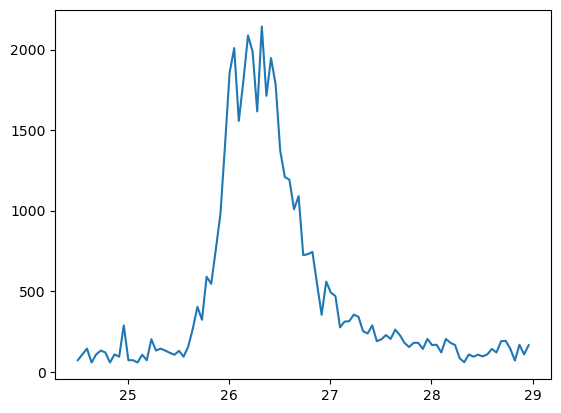

In [30]:
pyplot.plot(time, intensity)

In [34]:
def normal_posterior(baseline, height, time, mean, std):
    """
    Define a normally distributed posterior.

    Parameters
    ----------
    baseline
        baseline of the data
    height
        height of the normal distribution
    time
        numpy array with the time values of the relevant timeframe
    mean
        arithmetic mean of the normal distribution
    std
        standard deviation of the normal distribution

    Returns
    -------
    Probability density function (PDF) of the normally distributed posterior
    """
    return baseline + height * pt.exp(-0.5 * ((time - mean) / std) ** 2)


def define_model_normal(time, intensity):
    """
    Define a model for fitting a normal distribution to the peak data.

    Parameters
    ----------
    time
        numpy array with the time values of the relevant timeframe
    intensity
        numpy array with the intensity values of the relevant timeframe

    Returns
    -------
    pmodel
        pymc model
    """
    intercept_guess, slope_guess, noise_width_guess = initial_guesses(time, intensity)
    print(intercept_guess, slope_guess, noise_width_guess)
    with pm.Model() as pmodel:
        # priors plus error handling in case of mathematically impermissible values
        if intercept_guess == 0:
            baseline_intercept = pm.Normal("baseline_intercept", intercept_guess, 20)
        else:
            baseline_intercept = pm.Normal(
                "baseline_intercept", intercept_guess, abs(intercept_guess) / 2
            )
        baseline_slope = pm.Normal("baseline_slope", slope_guess, abs(slope_guess * 2) + 1)
        baseline = pm.Deterministic("baseline", baseline_intercept + baseline_slope * time)
        # since log(0) leads to -inf, this case is handled by setting noise_width_guess to 10
        if noise_width_guess > 0:
            noise = pm.LogNormal("noise", np.log(noise_width_guess), 1)
        elif noise_width_guess == 0:
            noise = pm.LogNormal("noise", np.log(10), 1)
        # define priors for parameters of a normally distributed posterior
        mean = pm.Normal("mean", np.mean(time[[0, -1]]), np.ptp(time) / 2)
        std = pm.HalfNormal("std", np.ptp(time) / 3)
        height = pm.HalfNormal("height", 0.95 * np.max(intensity))
        area = pm.Deterministic("area", height / (1 / (std * np.sqrt(2 * np.pi))))
        sn = pm.Deterministic("sn", height / noise)
        # posterior
        y = normal_posterior(baseline, height, time, mean, std)
        y = pm.Deterministic("y", y)

        # likelihood
        L = pm.Normal("L", mu=y, sigma=noise, observed=intensity)

    return pmodel

In [35]:
modell = define_model_normal(time, intensity)

5.623609510012073 -45.62944290095419 108.0


In [33]:
modell

baseline_intercept ~ N(5.62, 2.81)
    baseline_slope ~ N(-45.6, 92.3)
          baseline ~ Deterministic(f(baseline_intercept, baseline_slope))
                 L ~ N(y, noise)